In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

In [2]:
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: /content/sonnets.txt
100% 93.6k/93.6k [00:00<00:00, 78.0MB/s]


In [3]:
SONNETS_FILE = './sonnets.txt'

with open('./sonnets.txt') as f:
    data = f.read()

corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
corpus[0]

'from fairest creatures we desire increase,'

In [6]:
tokenizer.texts_to_sequences(corpus[0])

[[],
 [],
 [58],
 [],
 [],
 [],
 [17],
 [6],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [17],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [6],
 [],
 [],
 [],
 [6],
 [],
 [],
 [],
 [],
 [17],
 [],
 [],
 []]

In [7]:
tokenizer.texts_to_sequences([corpus[0]])

[[34, 417, 877, 166, 213, 517]]

In [8]:
tokenizer.texts_to_sequences([corpus[0]])[0]

[34, 417, 877, 166, 213, 517]

In [17]:
def n_gram_seqs(corpus, tokenizer):

    input_sequences = []

    for line in corpus:
      token_list = tokenizer.texts_to_sequences([line])[0]

      for i in range(1,len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
    
    max_sequence_len = max([len(x) for x in input_sequences])
    return input_sequences

In [10]:
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [11]:
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[[8, 878],
 [8, 878, 134],
 [8, 878, 134, 351],
 [8, 878, 134, 351, 102],
 [8, 878, 134, 351, 102, 156],
 [8, 878, 134, 351, 102, 156, 199],
 [16, 22],
 [16, 22, 2],
 [16, 22, 2, 879],
 [16, 22, 2, 879, 61],
 [16, 22, 2, 879, 61, 30],
 [16, 22, 2, 879, 61, 30, 48],
 [16, 22, 2, 879, 61, 30, 48, 634],
 [25, 311],
 [25, 311, 635],
 [25, 311, 635, 102],
 [25, 311, 635, 102, 200],
 [25, 311, 635, 102, 200, 25],
 [25, 311, 635, 102, 200, 25, 278]]

In [12]:
input_sequences = n_gram_seqs(corpus, tokenizer)

max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


In [13]:
def pad_seqs(input_sequences, maxlen):

    padded_sequences = np.array(pad_sequences(input_sequences, maxlen=maxlen, padding='pre'))  
    return padded_sequences

In [14]:
first_padded_seq = pad_seqs(first_example_sequence, len(first_example_sequence))
first_padded_seq

array([[  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213],
       [417, 877, 166, 213, 517]], dtype=int32)

In [15]:
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[  0,   0,   0,   0,   0,   0,   8, 878],
       [  0,   0,   0,   0,   0,   8, 878, 134],
       [  0,   0,   0,   0,   8, 878, 134, 351],
       [  0,   0,   0,   8, 878, 134, 351, 102],
       [  0,   0,   8, 878, 134, 351, 102, 156],
       [  0,   8, 878, 134, 351, 102, 156, 199],
       [  0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,  16,  22,   2, 879,  61],
       [  0,   0,  16,  22,   2, 879,  61,  30],
       [  0,  16,  22,   2, 879,  61,  30,  48],
       [ 16,  22,   2, 879,  61,  30,  48, 634],
       [  0,   0,   0,   0,   0,   0,  25, 311],
       [  0,   0,   0,   0,   0,  25, 311, 635],
       [  0,   0,   0,   0,  25, 311, 635, 102],
       [  0,   0,   0,  25, 311, 635, 102, 200],
       [  0,   0,  25, 311, 635, 102, 200,  25],
       [  0,  25, 311, 635, 102, 200,  25, 278]], dtype=int32)

In [16]:
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


In [18]:
def features_and_labels(input_sequences, total_words):

    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)
    return features, one_hot_labels

In [19]:
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features

labels have shape: (5, 3211)

features look like this:



array([[  0,   0,   0,  34],
       [  0,   0,  34, 417],
       [  0,  34, 417, 877],
       [ 34, 417, 877, 166],
       [417, 877, 166, 213]], dtype=int32)

In [20]:
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


In [21]:
def create_model(total_words, max_sequence_len):

    model = Sequential()
    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(300)))
    model.add(Dense(total_words,activation='softmax'))


    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [22]:
model = create_model(total_words, max_sequence_len)
history = model.fit(features, labels, epochs=50, verbose=1)

Epoch 1/50
484/484 [==============================] - 56s 107ms/step - loss: 6.8473 - accuracy: 0.0248
Epoch 2/50
484/484 [==============================] - 52s 108ms/step - loss: 6.3831 - accuracy: 0.0325
Epoch 3/50
484/484 [==============================] - 52s 107ms/step - loss: 6.1298 - accuracy: 0.0464
Epoch 4/50
484/484 [==============================] - 52s 108ms/step - loss: 5.8534 - accuracy: 0.0559
Epoch 5/50
484/484 [==============================] - 52s 107ms/step - loss: 5.5157 - accuracy: 0.0682
Epoch 6/50
484/484 [==============================] - 52s 108ms/step - loss: 5.0783 - accuracy: 0.0849
Epoch 7/50
484/484 [==============================] - 52s 108ms/step - loss: 4.5370 - accuracy: 0.1167
Epoch 8/50
484/484 [==============================] - 52s 108ms/step - loss: 3.9048 - accuracy: 0.1911
Epoch 9/50
484/484 [==============================] - 52s 108ms/step - loss: 3.2663 - accuracy: 0.3039
Epoch 10/50
484/484 [==============================] - 53s 110ms/step - l

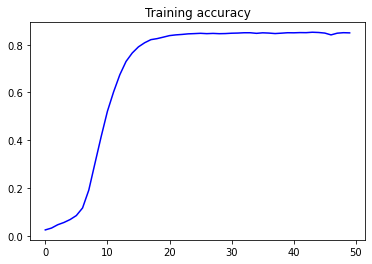

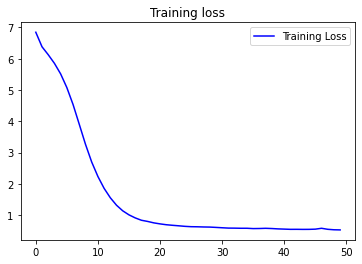

In [24]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

In [25]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict(token_list, verbose=0)
	predicted = np.argmax(predicted, axis=-1).item()
	output_word = tokenizer.index_word[predicted]
	seed_text += " " + output_word

print(seed_text)

Help me Obi Wan Kenobi, you're my only hope my love's is go new new new ' now live to you heart you for his love heart still room room room room men's spite of thee leaves me by grow by gems can now give abuse me forth a tomb to rehearse strange dead give me of hate blind hate me than me again truth with heat been night can stand them o'er forth art the sad eye new and his show his verse ' hide to bear this part me keen and rare gems gems tongue again by parts kind perusal sweet far far find tongue new faith
